In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform as transform
import cv2 as cv

project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) # scratch folder
if project_root not in sys.path:
    sys.path.append(project_root)

import importlib
from src.medsam_segmentation import MedSAMTool
from src.data_io import ImageData

In [2]:
def convert_string_to_function(func_str, func_name):
    """ 
    Given a string representation of a function, convert it to an actual function object. 
    """
    # Create a namespace dictionary to store the function
    namespace = {}

    # Execute the function string in this namespace
    exec(func_str, globals(), namespace)

    # Return the function object from the namespace
    return namespace[func_name]

def expert_preprocess_images_func(images, is_rgb=False):
    """
    Given an ImageData object, apply the preprocessing methods mentioned in the original MedSAM paper. 
    We consider this to be the expert preprocessing function.
    """
    resized_imgs = images.raw
    for i in range(len(resized_imgs)):
        img_np = resized_imgs[i]
        if is_rgb:
            resized_imgs[i] = np.uint8((img_np - img_np.min()) / (np.max(img_np) - np.min(img_np)) * 255.0)
        else:
            lower_bound, upper_bound = np.percentile(img_np[img_np > 0], 0.5), np.percentile(img_np[img_np > 0], 99.5)
            img_np_pre = np.clip(img_np, lower_bound, upper_bound)
            img_np_pre = (img_np_pre - np.min(img_np_pre)) / (np.max(img_np_pre) - np.min(img_np_pre)) * 255.0
            img_np_pre[img_np == 0] = 0
            resized_imgs[i] = np.uint8(img_np_pre)
    return ImageData(raw=resized_imgs, batch_size=images.batch_size)

def get_green_translucent_mask(mask, alpha=0.4):
        """Return an RGBA mask: green where mask==1, fully transparent elsewhere."""
        mask_np = mask.cpu().numpy() if hasattr(mask, "cpu") else np.array(mask)
        rgba = np.zeros((*mask_np.shape, 4), dtype=float)
        rgba[..., 0] = 0.0
        rgba[..., 1] = 1.0
        rgba[..., 2] = 0.0
        rgba[..., 3] = (mask_np > 0).astype(float) * alpha
        return rgba

In [3]:
# Get the highest ranked agent preprocessing function string for the validation set
# https://github.com/sstilz/sci-agent/blob/0_dermoscopy_main/output/dermoscopy-main/medSAM_segmentation/top_k_agg_functions.json#L4C35-L4C1277
dermoscopy_agent_preprocess_function_string = "def preprocess_images(images: ImageData) -> ImageData:\n    # Variant: Sharpen after CLAHE + GaussianBlur, then normalize\n    processed_images_list = []\n    for img in images.raw:\n        img = np.copy(img)\n        img = cv.resize(img, (1024, 1024), interpolation=cv.INTER_AREA)\n        img = cv.GaussianBlur(img, (3, 3), 0)\n        if img.shape[2] == 3:\n            clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))\n            channels = cv.split(img)\n            eq_channels = [\n                clahe.apply(cv.normalize(c, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8))\n                for c in channels\n            ]\n            img = cv.merge(eq_channels)\n        else:\n            img = cv.equalizeHist(cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8))\n            img = np.expand_dims(img, axis=-1)\n        # Sharpening kernel\n        kernel = np.array([[0, -1, 0],\n                           [-1, 5, -1],\n                           [0, -1, 0]])\n        img = cv.filter2D(img, -1, kernel)\n        img = img.astype(np.float32) / 255.0\n        processed_images_list.append(img)\n    output_data = ImageData(raw=processed_images_list, batch_size=images.batch_size)\n    return output_data"

# https://github.com/sstilz/sci-agent/blob/xray-main/output/xray-main/medSAM_segmentation/aggregated_top_10_test_results.json#L34C36-L34C751
xray_agent_preprocess_function_string = "def preprocess_images(images: ImageData) -> ImageData:\n    # Strategy 1: Unsharp masking with moderate Gaussian blur (reference top box, slight variation in alpha)\n    processed_images_list = []\n    for img_array in images.raw:\n        img_array = np.copy(img_array)\n        sigma = 1.2\n        ksize = (5, 5)\n        blurred = cv.GaussianBlur(img_array, ksize, sigma)\n        alpha = 1.3\n        sharpened = cv.addWeighted(img_array, 1 + alpha, blurred, -alpha, 0)\n        processed_img = np.clip(sharpened, 0, 255).astype(img_array.dtype)\n        processed_images_list.append(processed_img)\n    output_data = ImageData(raw=processed_images_list, batch_size=images.batch_size)\n    return output_data"

In [4]:
def pipeline(image_indices, image_file, is_rgb, gpu_id, checkpoint_path, batch_size, agent_preprocess_images_func, output_file_path):
    segmenter = MedSAMTool(gpu_id=gpu_id, checkpoint_path=checkpoint_path)
    raw_images, boxes, masks = segmenter.loadData(image_file)
    images = ImageData(raw=raw_images,
                batch_size=batch_size,
                image_ids=[i for i in range(len(raw_images))],
                masks=masks,
                predicted_masks=masks)
                    
    agent_preprocessed_images = agent_preprocess_images_func(images)
    agent_pred = segmenter.predict(agent_preprocessed_images, boxes, used_for_baseline=False, is_rgb=is_rgb)

    expert_preprocessed_images = expert_preprocess_images_func(images, is_rgb=is_rgb)
    expert_pred = segmenter.predict(expert_preprocessed_images, boxes, used_for_baseline=False, is_rgb=is_rgb)


    rows, cols = 3, len(image_indices)  # 3 rows (Raw, Agent, Expert)

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    fig.subplots_adjust(
        wspace=0.01,  # Smaller horizontal gap between images
        hspace=0.01,  # Smaller vertical gap between rows
        left=0.01,     # Margin for row labels
        right=0.99,
        top=0.99,
        bottom=0.01,
    )
    row_labels = ["Raw", "Agent Preprocessed", "Expert Preprocessed"]

    for col_idx, i in enumerate(image_indices):
        image = images.raw[i]
        agent_image = agent_preprocessed_images.raw[i]
        expert_image = expert_preprocessed_images.raw[i]
        agent_mask = agent_pred[i]
        expert_mask = expert_pred[i]
        box = boxes[i][0]

        # Row 0: Raw
        ax = axes[0, col_idx]
        ax.imshow(np.clip(image, 0, 255).astype(np.uint8))
        ax.imshow(get_green_translucent_mask(images.masks[i]), interpolation='none',
                    extent=(0, image.shape[1], image.shape[0], 0))
        ax.add_patch(
            plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                        fill=False, edgecolor='red', linewidth=1)
        )
        ax.axis("off")

        # Row 1: Agent Preprocessed
        ax = axes[1, col_idx]
        ax.imshow(np.clip(agent_image, 0, 1))
        ax.imshow(get_green_translucent_mask(agent_mask), interpolation='none',
                extent=(0, agent_image.shape[1], agent_image.shape[0], 0))
        ax.add_patch(
            plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                        fill=False, edgecolor='red', linewidth=1)
        )
        ax.axis("off")

        # Row 2: Expert Preprocessed
        ax = axes[2, col_idx]
        ax.imshow(np.clip(expert_image, 0, 255).astype(np.uint8))
        ax.imshow(get_green_translucent_mask(expert_mask), interpolation='none',
                extent=(0, expert_image.shape[1], expert_image.shape[0], 0))
        ax.add_patch(
            plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                        fill=False, edgecolor='red', linewidth=1)
        )
        ax.axis("off")

    for row_idx, label in enumerate(row_labels):
        bbox = axes[row_idx, 0].get_position()
        y_center = (bbox.y0 + bbox.y1) / 2  # Vertical center of the row
        x_pos = bbox.x0 - 0.01              # A bit to the left of the first image

        fig.text(x_pos, y_center, label, rotation=90, va='center', ha='right', fontsize=12)
    
    plt.show()

    if not os.path.exists(os.path.dirname(output_file_path)):
        os.makedirs(os.path.dirname(output_file_path))
    fig.savefig(output_file_path, dpi=300, bbox_inches='tight', pad_inches=0.1)

In [5]:
# Shared params (these are the same across xray and dermoscopy)
gpu_id = 4
batch_size = 8
checkpoint_path = "../data/medsam_vit_b.pth"



In _build_sam() with cuda:4
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...

Inside medsam_inference()
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...


In _build_sam() with cuda:4
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...

Inside medsam_inference()
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...


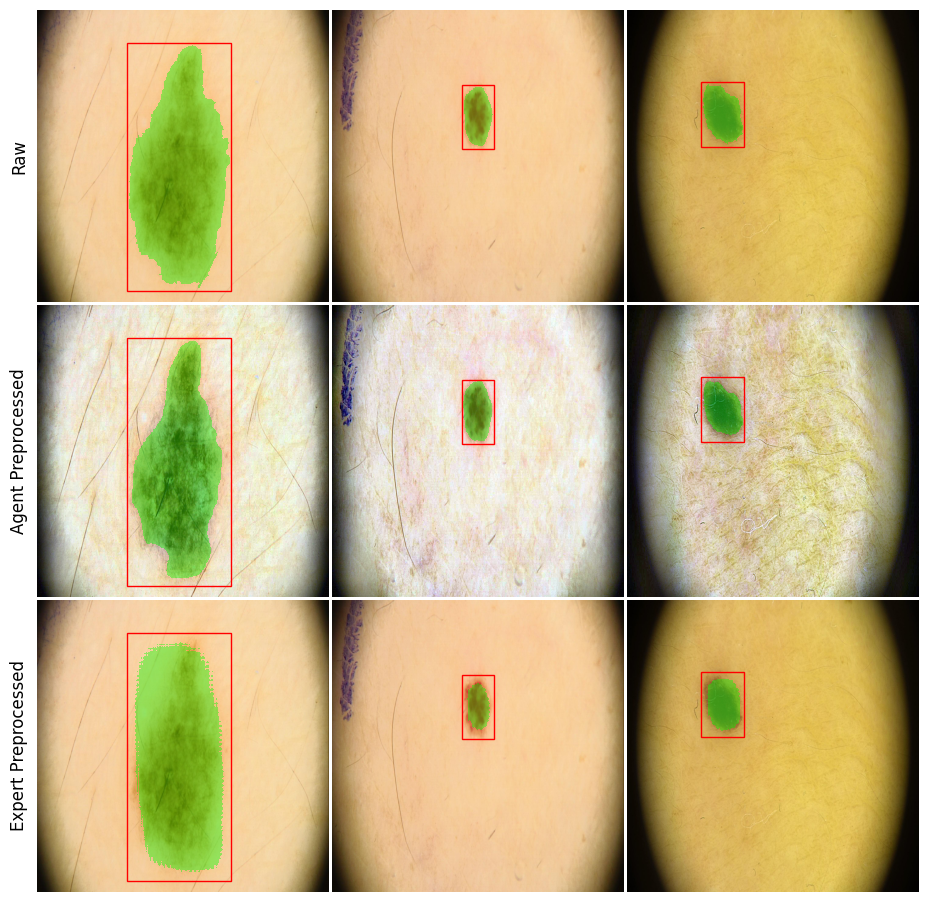

In [6]:
# Get Dermoscopy Visualizations
output_file_path = "_figures/dermoscopy_agent_expert_preprocessed.png"
agent_preprocess_images_func = convert_string_to_function(dermoscopy_agent_preprocess_function_string, "preprocess_images")
image_file = "../data/resized_dermoscopy_val_filenames_25.pkl"
is_rgb = True  # dermoscopy images are in color
image_indices = [13, 23, 8]

pipeline(image_indices, image_file, is_rgb, gpu_id, checkpoint_path, batch_size, agent_preprocess_images_func, output_file_path)



In _build_sam() with cuda:4
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...

Inside medsam_inference()
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...


In _build_sam() with cuda:4
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...

Inside medsam_inference()
Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...


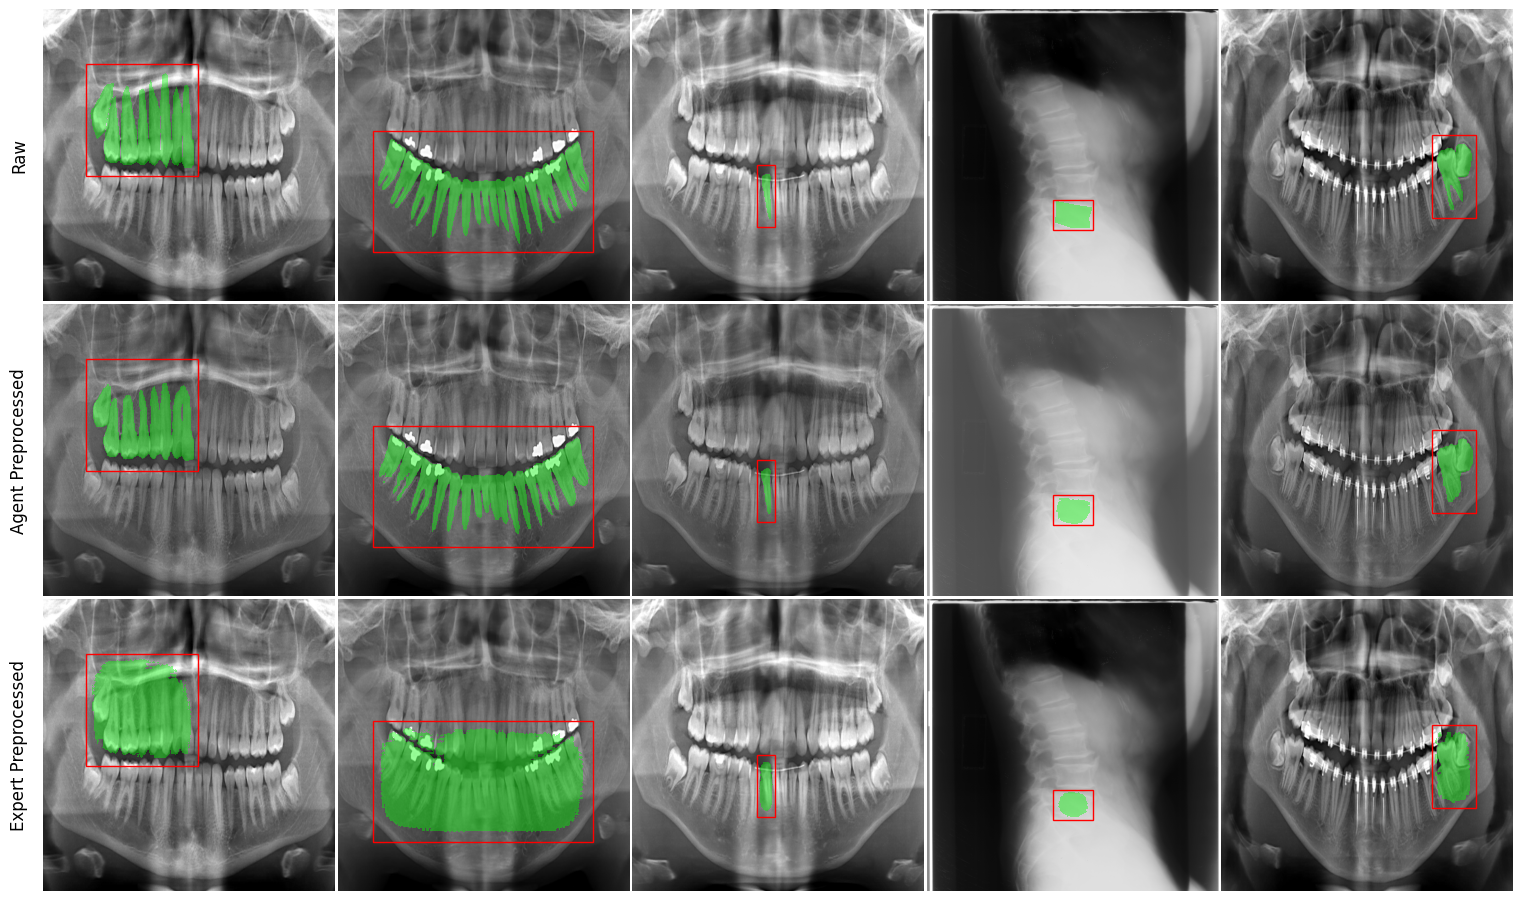

In [7]:
# Get X-Ray Visualizations
output_file_path = "_figures/xray_agent_expert_preprocessed.png"
agent_preprocess_images_func = convert_string_to_function(xray_agent_preprocess_function_string, "preprocess_images")
image_file = "../data/resized_xray_val_filenames_25.pkl"
is_rgb = False  # xray images are grayscale
image_indices = [12, 15, 16, 18, 23]
pipeline(image_indices, image_file, is_rgb, gpu_id, checkpoint_path, batch_size, agent_preprocess_images_func, output_file_path)